<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Предобработка данных</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Тренды-и-сезонность" data-toc-modified-id="Тренды-и-сезонность-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Тренды и сезонность</a></span></li><li><span><a href="#Скользящее-среднее" data-toc-modified-id="Скользящее-среднее-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Скользящее среднее</a></span></li><li><span><a href="#Проверка-на-стационарность" data-toc-modified-id="Проверка-на-стационарность-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Проверка на стационарность</a></span></li><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Создание признаков</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#XGBRegressor" data-toc-modified-id="XGBRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>XGBRegressor</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LinearRegression</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# загрузка библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
import time

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [2]:
# чтение файла с данными и сохранение в переменную df
try:
    df = pd.read_csv('C:/Users/79853/Documents/datascience/yandex/Спринт13/taxi.csv')
except:
    df = pd.read_csv('/datasets/taxi.csv') # загрузка онлайн

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


In [5]:
df.sort_values('datetime')

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


**Признаки:**
- **datetime** - дата и время
- **num_orders** - количество заказов

In [6]:
# подсчёт явных дубликатов
df.duplicated().sum()

0

В датасете представлены данные о заказах такси за 6 месяцев: **марта–август 2018 года**. Данные о заказах записаны через интервал **10 минут**.

В данных нет пропусков и дубликатов.

Поле `datetime` необходимо перевести в формат **datetime**, сделать индесом и проверить, в хронологическом ли порядке расположены даты и время.

В соответствии с заданием данные необходимо ресемплировать по одному часу.

### Предобработка данных

In [7]:
# изменение типа данных c object на datetime64
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%dT%H:%M:%S')

In [8]:
# установка индекса
df = df.set_index('datetime')

In [9]:
# проверка на монотонность
df.index.is_monotonic

True

In [10]:
# Ресемплирование данных
df_h = df.resample('1H').sum()  # по одному часу
df_d = df.resample('1D').sum()  # по одному дню
df_w = df.resample('1W').sum()  # по одной недели
df_m = df.resample('1M').sum()  # по одному месяцу

## Анализ

Посмотрим на графики временных рядов исходного датасета и ресемплированных рядов.

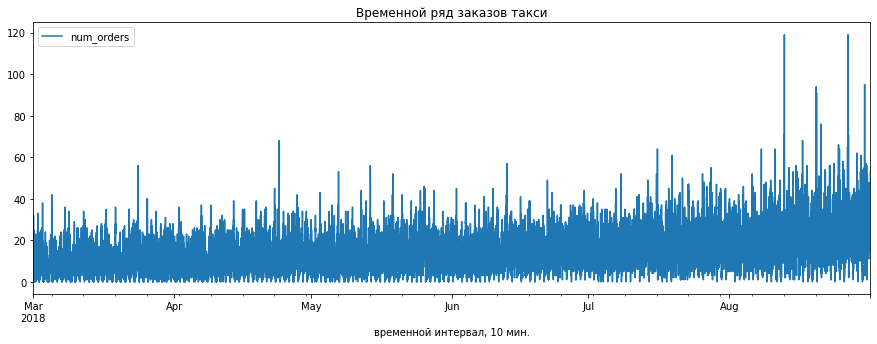

In [11]:
df.plot(figsize=(15,5), title='Временной ряд заказов такси').set_xlabel('временной интервал, 10 мин.');

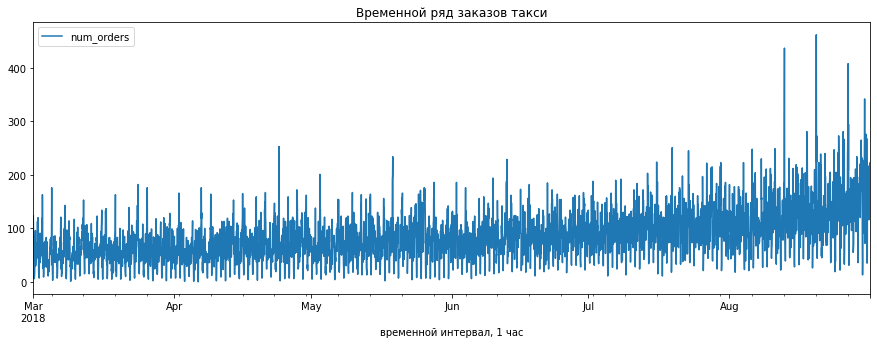

In [12]:
df_h.plot(figsize=(15,5), title='Временной ряд заказов такси').set_xlabel('временной интервал, 1 час');

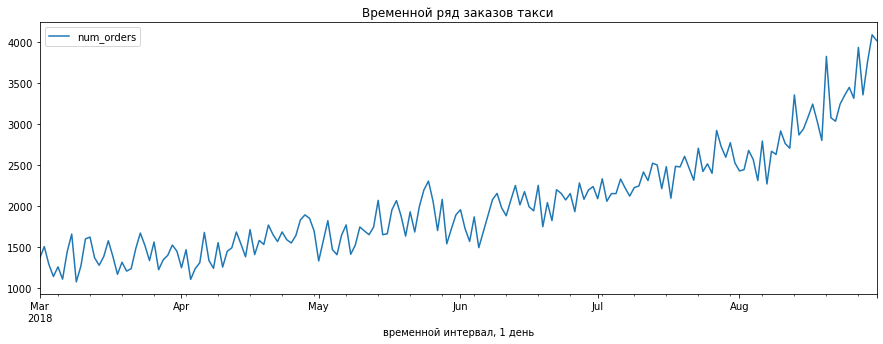

In [13]:
df_d.plot(figsize=(15,5), title='Временной ряд заказов такси').set_xlabel('временной интервал, 1 день');

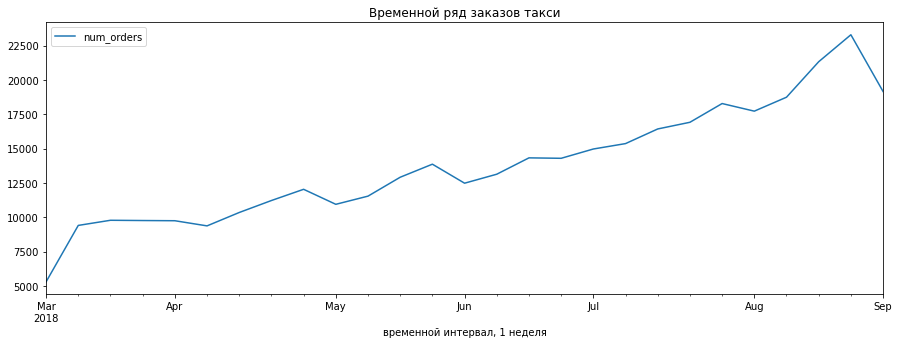

In [14]:
df_w.plot(figsize=(15,5), title='Временной ряд заказов такси').set_xlabel('временной интервал, 1 неделя');

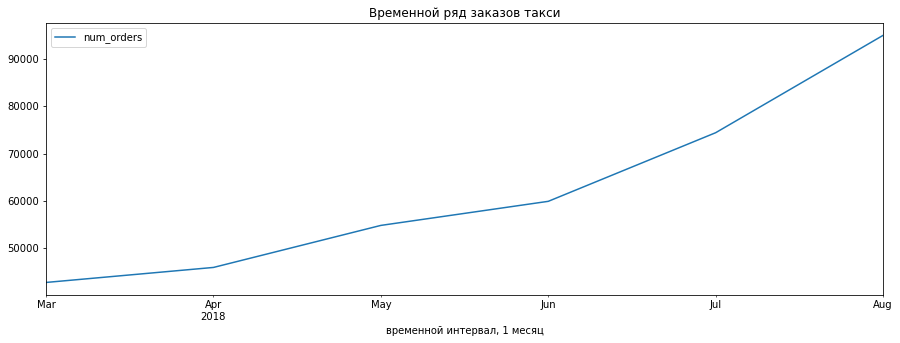

In [15]:
df_m.plot(figsize=(15,5), title='Временной ряд заказов такси').set_xlabel('временной интервал, 1 месяц');

Ресемплированные данные позволяют построить более читаемый график, нежели исходные данные.

График показывает рост заказов такси на протяжении всего рассматриваемого временного ряда.

### Тренды и сезонность

Посмотрим на тренд и сезонную компоненту временного ряда, ресемплированного по часу, за 6 месяцев, месяц, неделю и день.

In [16]:
decomposed = seasonal_decompose(df_h['num_orders'])

In [17]:
# функция для построения графиков тренда и сезонности за различные интервалы времени
def trend_seasonal_plot(title, start=df.index[0], end=df.index[-1]):
    plt.figure(figsize=(12, 6))
    plt.subplot(211)
    # Чтобы график корректно отобразился, указываем его оси ax, равными plt.gca() - get current axis, получить текущие оси
    decomposed.trend[start:end].plot(ax=plt.gca()).set_xlabel('временной интервал, 1 час')
    plt.title(f'Тренд за {title}')
    plt.subplot(212)

    decomposed.seasonal[start:end].plot(ax=plt.gca()).set_xlabel('временной интервал, 1 час')
    plt.title(f'Сезонность за {title}')

    plt.tight_layout()

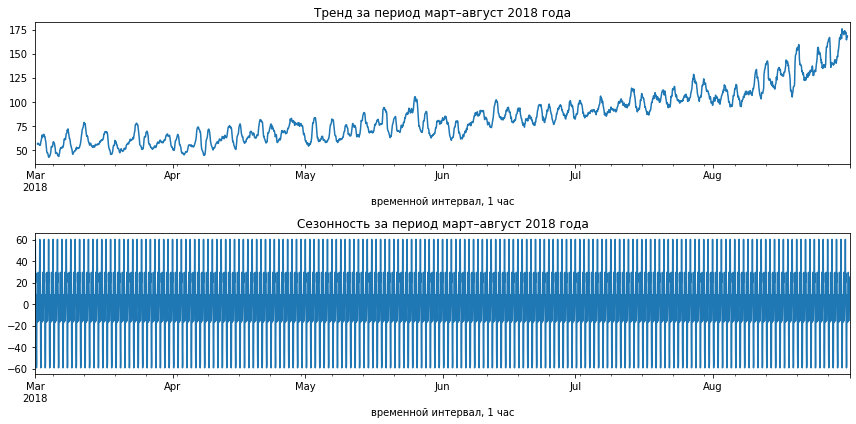

In [18]:
trend_seasonal_plot(title='период март–август 2018 года')

За полгода прослеживается тренд увеличения заказов с мая по август. 

По графику сезонности пока что-то рассмотреть довольно сложно. Единственное, можно сказать, что присутствует некая постоянная закономерность.

Для определения месячного тренда лучше взять месяц, в котором нет праздничных дней (дополнительных выходных), которые безусловно будут влиять на тренд. В рассматриваемом периоде таким месяцем является, например, июль. Возьмем его.

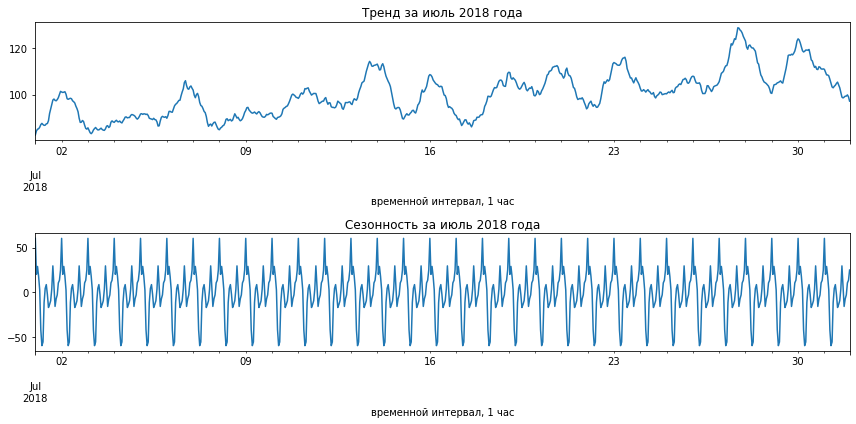

In [19]:
trend_seasonal_plot(title='июль 2018 года', start='2018-07-01', end='2018-07-31')

Тренд как таковой в течение месяца не прослеживается, наблюдается попеременное увеличение и снижение количества заказов, которое связано со днями недели, также виден общий тренд увеличения заказов к августу.

На графике сезонности за месяц уже можно отследить суточную сезонность.

Чтобы посмотреть тренд и сезонность за неделю с **пн** по **вс**, посмотрим на календарь и выберем одну неделю в июне 2018 года. Чтобы увидеть правильный тренд и сезонность за неделю, необходимо выбрать неделю без праздничных дней, когда люди больше путешествуют, а значит и чаще посещают аэропорты.

In [20]:
c = calendar.TextCalendar(calendar.MONDAY)
june = c.formatmonth(2018, 6)
print(june)

     June 2018
Mo Tu We Th Fr Sa Su
             1  2  3
 4  5  6  7  8  9 10
11 12 13 14 15 16 17
18 19 20 21 22 23 24
25 26 27 28 29 30



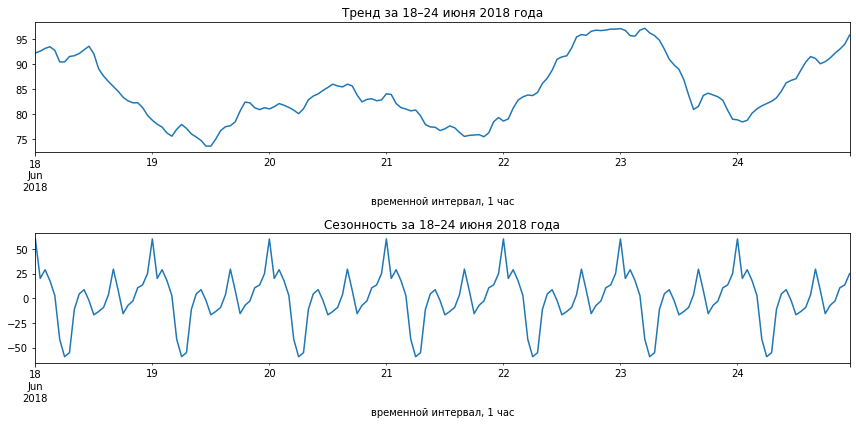

In [21]:
trend_seasonal_plot(title='18–24 июня 2018 года', start='2018-06-18', end='2018-06-24')

На графике тренда за неделю прослеживается увеличение количества заказов в **пн** и в **сб**. Т.к. в рассматриваемом датасете представлены данные о заказах такси в аэропортах, то можно предположить, что такой тренд связан с тем, что в пн часто улетают в командировки, а в сб - в отпуск или на выходные.

На графике сезонности за неделю еще более наглядно прослеживается суточная сезонность.

Посмотрим на график тренда недели, в которой пн и вт были выходными днями.

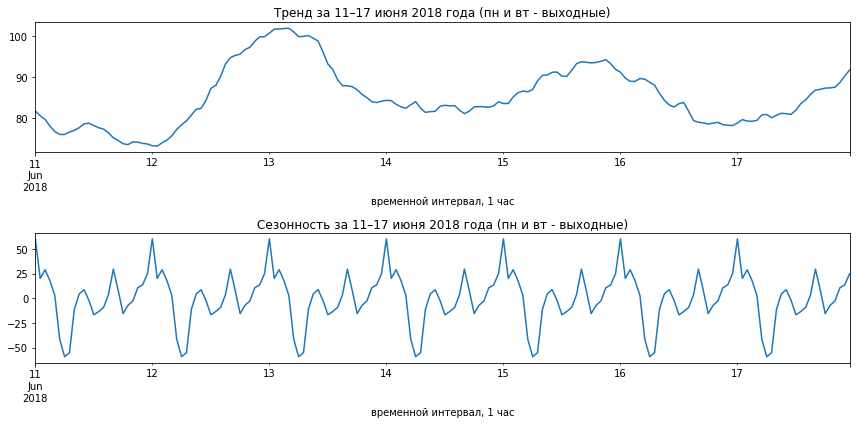

In [22]:
trend_seasonal_plot(title='11–17 июня 2018 года (пн и вт - выходные)', start='2018-06-11', end='2018-06-17')

На графике тренда недели с дополнительными выходными днями в пн и вт видно, что пик заказов такси приходится на среду. Это подтверждает гипотезу про командировки - в первый день после выходных чаще всего начинаются рабочие поездки. В субботу также прослеживается увеличение - это поездки на выходные.

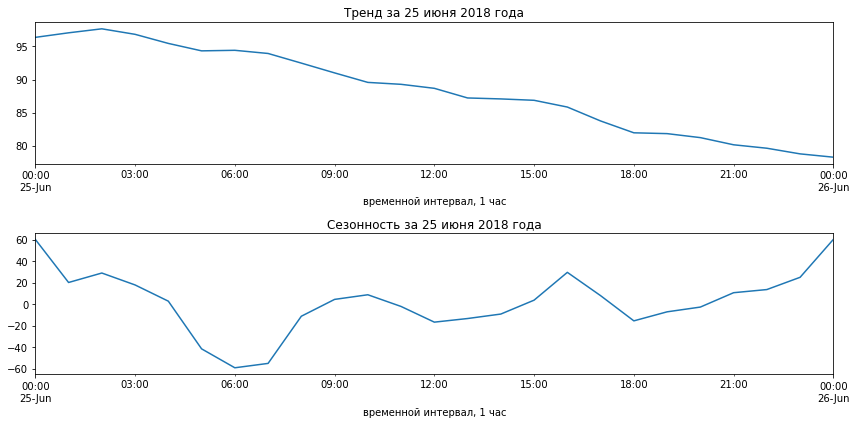

In [23]:
trend_seasonal_plot(title='25 июня 2018 года', start='2018-06-25 00:00:00', end='2018-06-26 00:00:00')

На графике тренда за один день виден нисходящий тренд: количество заказов в ночное время больше, чем в дневное и вечернее.

График сезонности за один день показывает, что меньше всего заказов приходится на 6 утра, больше всего - на 12 ночи. Снижение заказов такси в аэропортах в 6 утра и увеличение к полуночи можно объяснить тем, что на раннее утреннее время приходятся прилеты ночных рейсов, а на полночь - дневных, по статистике же более половины пассажиров отдают предпочтение утренним и дневным рейсам, нежели ночным.

### Скользящее среднее

Посмотрим на скользящее среднее по дням и по неделям.

In [24]:
df_h['day_rolling_mean'] = df_h['num_orders'].rolling(24).mean()
df_h['week_rolling_mean'] = df_h['num_orders'].rolling(24*7).mean()

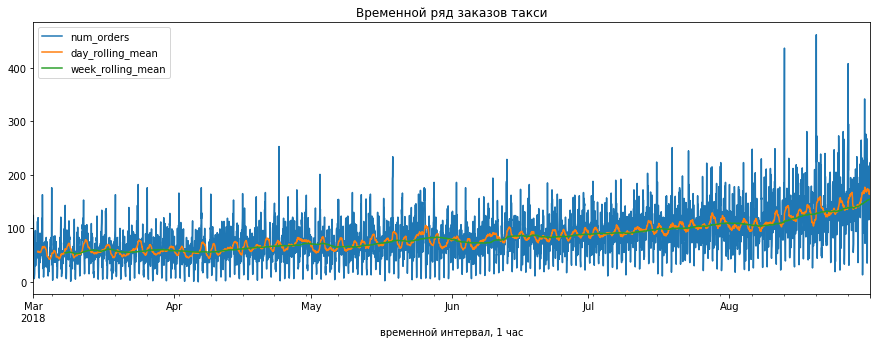

In [25]:
df_h.plot(figsize=(15,5), title='Временной ряд заказов такси').set_xlabel('временной интервал, 1 час');

Сглаживание по дням лучше показывает динамику заказов в течение недели, а недельное сглаживание хорошо отражает общие изменения, связанные с ростом заказов к августу.

### Проверка на стационарность

Прогнозировать данные помогают стационарные ряды. Проверим исследуемый временной ряд на стационарность с помощью **теста Дики–Фуллера**, в котором выдвигаются гипотезы:
- Нулевая гипотеза: ряд нестационарный.
- Альтернативная гипотеза: ряд стационарный.

In [26]:
# функция для проверки ряда на стационарность по тесту Дики-Фуллера
def dfuller_test(series):
    X = series.values
    result = adfuller(X)
    adf = result[0]
    p_value = result[1]
    print('ADF Statistic: %f' % adf)
    print('p-value: %f' % p_value)
    if p_value < 0.05:
        print('Отклоняем нулевую гипотезу - Ряд стационарный')
    else:
        print('Принимаем нулевую гипотезу - Ряд нестационарный')
        
    value_1 = result[4]['1%']
    value_5 = result[4]['5%']
    value_10 = result[4]['10%']
    
    if adf < value_1:
        print('Нулевая гипотеза может быть отклонена с уровнем значимости менее 1%')
    elif value_1 < adf < value_5:
        print('Нулевая гипотеза может быть отклонена с уровнем значимости 1–5%')
    elif value_5 < adf < value_10:
        print('Нулевая гипотеза может быть отклонена с уровнем значимости 5–10%')  

Проверим на стационарность исходный датасет и ресемплированный ряд по часу.

In [27]:
datasets = {'Временной ряд по 10 мин.': df,
            'Временной ряд по 1 часу': df_h}
for key in datasets:
    print("\033[1m" + key + "\033[0;0m")
    dfuller_test(datasets[key]['num_orders'])
    print()

Временной ряд по 10 мин.
ADF Statistic: -12.548885
p-value: 0.000000
Отклоняем нулевую гипотезу - Ряд стационарный
Нулевая гипотеза может быть отклонена с уровнем значимости менее 1%

Временной ряд по 1 часу
ADF Statistic: -3.068924
p-value: 0.028940
Отклоняем нулевую гипотезу - Ряд стационарный
Нулевая гипотеза может быть отклонена с уровнем значимости 1–5%



Исходный временной ряд является стационарным с довольно низким отрицательным значением ADF Statistic.

Временной ряд, ресемплированный по одному часу, также является стационарным, однако в этом случае значение ADF Statistic выше, но всё ещё отрицательное. Вероятность того, что результат является статистической случайностью составляет 1-5%.

### Создание признаков

Добавим в рабочий датасет признаки, которые помогут улучшить предсказания моделей:
- **month** - месяц,
- **day** - число месяца,
- **is_weekend** - выходной день или рабочий,
- **weekday_average** - среднее значение заказов по дням недели,
- **hour_average** - среднее значение заказов по часам,
- **lag_1, lag_2...** - отстающие значения,
- **rolling_mean** - скользящее среднее.

In [28]:
# список выходных и праздничных дней на рассматриваемый период
weekends = ['2018-03-03', '2018-03-04', '2018-03-08', '2018-03-09', '2018-03-10', '2018-03-11', '2018-03-17',
            '2018-03-18', '2018-03-24', '2018-03-25', '2018-03-31', '2018-04-01', '2018-04-07', '2018-04-08',
            '2018-04-14', '2018-04-15', '2018-04-21', '2018-04-22', '2018-04-29', '2018-04-30', '2018-05-01',
            '2018-05-02', '2018-05-05', '2018-05-06', '2018-05-09', '2018-05-12', '2018-05-13', '2018-05-19',
            '2018-05-20', '2018-05-26', '2018-05-27', '2018-06-02', '2018-06-03', '2018-06-10', '2018-06-11',
            '2018-06-12', '2018-06-16', '2018-06-17', '2018-06-23', '2018-06-24', '2018-06-30', '2018-07-01',
            '2018-07-07', '2018-07-08', '2018-07-14', '2018-07-15', '2018-07-21', '2018-07-22', '2018-07-28',
            '2018-07-29', '2018-08-04', '2018-08-05', '2018-08-11', '2018-08-12', '2018-08-18', '2018-08-19',
            '2018-08-25', '2018-08-26']

In [29]:
# функция для добавления признаков и разделения датасета на train, test и features, target
def prepare_data(data, test_size, target, lag_start, lag_end, rolling_mean_size):
    
    data = data.loc[:,[target]]
    
    # индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем календарные признаки
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['weekday'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    # добавляем признак выходной день / рабочий - 1 / 0
    data['is_weekend'] = 0
    for i in range(len(data)):
        date = data.index[i].strftime('%Y-%m-%d')
        if date in weekends:
            data.iloc[i, -1] = 1
    
    # функции для заполнения средних значений заказов по дням недели и по часам
    def weekday_average_f(weekday):
        mean_order = data.groupby('weekday')[target].mean()
        return mean_order[weekday]

    def hour_average_f(hour):
        mean_order = data.groupby('hour')[target].mean()
        return mean_order[hour]
    
    # считаем средние только по тренировочной части
    data.loc[:, 'weekday_average'] = data[:test_index]['weekday'].apply(weekday_average_f)
    data.loc[:, 'hour_average'] = data[:test_index]['hour'].apply(hour_average_f)
    
    # уберем поля, закодированные средними признаки 
    data.drop(["hour", "weekday"], axis=1, inplace=True)
    
    # добавляем отстающие значения
    for lag in range(lag_start, lag_end):
        data['lag_{}'.format(lag)] = data[target].shift(lag)
        
    # добавляем скользящее среднее
    data['rolling_mean'] = data[target].shift(lag_start).rolling(rolling_mean_size).mean()
    
    data = data.dropna()

    # разбиваем датасет на тренировочную и тестовую выборку
    train, test = train_test_split(data, shuffle=False, test_size=test_size, random_state=123)
    
    train_features = train.drop([target], axis=1)
    train_target = train[target]
    test_features = test.drop([target], axis=1)
    test_target = test[target]

    return train_features, train_target, test_features, test_target

## Обучение

Обучим несколько моделей:
- **RandomForestRegressor()**,
- **LGBMRegressor()**,
- **XGBRegressor()**,
- **LinearRegression()**

С помощью GridSearchCV() подберем значения нескольких гиперпараметров, которые влияют на качество предсказаний.

In [30]:
# функция для расчета ошибки RMSE
def rmse(target, predictions):
    return mean_squared_error(target, predictions, squared=False)

In [31]:
# функция для определения гиперпараметров модели
def grid_search(model, params):
    grid_cv = GridSearchCV(estimator=model,
                           param_grid=params,
                           cv=TimeSeriesSplit(n_splits=5),
                           n_jobs=-1,
                           scoring=make_scorer(rmse, greater_is_better=False))
    grid_cv.fit(train_features, train_target)
    
    print('Гиперпараметры: ', grid_cv.best_params_)
    print('RMSE:', int(abs(grid_cv.best_score_)))
    
    return grid_cv.best_params_

In [32]:
# функция для обучения модели и определения времени обучения
def fit_predict(model, name):
    start_fit_time = time.time()
    model.fit(train_features, train_target)
    fit_time = time.time() - start_fit_time
    
    predictions = model.predict(train_features)
    
    global a
    columns = ['model_name', 'model', 'time_sec', 'RMSE', 'process']
    rows = [[name, model, round(fit_time, 1), int(rmse(train_target, predictions)), 'обучение']]
    a = pd.DataFrame(data=rows, columns=columns)

In [33]:
# таблица для накопления результатов
columns = ['model_name', 'model', 'time_sec', 'RMSE', 'process']
result_tbl = pd.DataFrame(columns=columns)
result_tbl

,model_name,model,time_sec,RMSE,process


Значения полей таблицы с результатами:
- **model_name** – название модели,
- **model** – конфигурация модели,
- **time_sec** – время обучения/тестирования модели в секундах,
- **RMSE** – среднеквадратическая ошибка,
- **process** - обучение/тестирование.

Сформируем выборки. В качестве начального значения лагов возьмем единицу **lag_start=1**, т.к. нам необходимо построить предсказания на 1 час вперёд. Скользящее среднее посчитаем для суток **rolling_mean_size=24**, т.к. в данных наблюдается суточная сезонность.

In [34]:
train_features, train_target, test_features, test_target = prepare_data(data=df_h,
                                                                        test_size=0.1,
                                                                        target='num_orders',
                                                                        lag_start=1, lag_end=3,
                                                                        rolling_mean_size=24)

In [35]:
print("\033[1m" + 'Тренировочная выборка' + "\033[0;0m")
print('Начальная дата:', train_features.index.min())
print('Конечная дата:', train_features.index.max())
print()
print("\033[1m" + 'Тестовая выборка' + "\033[0;0m")
print('Начальная дата:', test_features.index.min())
print('Конечная дата:', test_features.index.max())

Тренировочная выборка
Начальная дата: 2018-03-02 00:00:00
Конечная дата: 2018-07-28 02:00:00

Тестовая выборка
Начальная дата: 2018-07-28 03:00:00
Конечная дата: 2018-08-13 13:00:00


### RandomForestRegressor

In [36]:
%%time
# подбор гиперпараметров для модели
best3 = grid_search(RandomForestRegressor(), params={'n_estimators': range(1, 100, 10),
                                                     'max_depth': range(1, 20, 2),
                                                     'random_state': [123]})

Гиперпараметры:  {'max_depth': 11, 'n_estimators': 71, 'random_state': 123}
RMSE: 23
Wall time: 24 s


In [37]:
rfreg = RandomForestRegressor(**best3)

In [38]:
fit_predict(rfreg, name='rfreg')
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу
result_tbl

,model_name,model,time_sec,RMSE,process
0,rfreg,"(DecisionTreeRegressor(max_depth=11, max_featu...",0.8,12,обучение


### LGBMRegressor

In [39]:
%%time
# подбор гиперпараметров для модели
best = grid_search(LGBMRegressor(), params={'num_iterations': range(100, 500, 20),
                                            'max_bin': [255, 455],
                                            'random_state': [123]})

Гиперпараметры:  {'max_bin': 255, 'num_iterations': 100, 'random_state': 123}
RMSE: 24
Wall time: 9.81 s


C:\Users\79853\miniconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [40]:
lgbmreg = LGBMRegressor(**best)

In [41]:
fit_predict(lgbmreg, name='lgbmreg')
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу
result_tbl

,model_name,model,time_sec,RMSE,process
0,rfreg,"(DecisionTreeRegressor(max_depth=11, max_featu...",0.8,12,обучение
0,lgbmreg,"LGBMRegressor(max_bin=255, num_iterations=100,...",0.1,14,обучение


### XGBRegressor

In [42]:
%%time
best2 = grid_search(XGBRegressor(), params={'max_depth': range(2, 20, 2), 'random_state': [123]})

Гиперпараметры:  {'max_depth': 2, 'random_state': 123}
RMSE: 24
Wall time: 5.87 s


In [43]:
xgbreg = XGBRegressor(**best2)

In [44]:
fit_predict(xgbreg, name='xgbreg')
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу
result_tbl

,model_name,model,time_sec,RMSE,process
0,rfreg,"(DecisionTreeRegressor(max_depth=11, max_featu...",0.8,12,обучение
0,lgbmreg,"LGBMRegressor(max_bin=255, num_iterations=100,...",0.1,14,обучение
0,xgbreg,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.1,19,обучение


### LinearRegression

In [45]:
linear = LinearRegression()

In [46]:
fit_predict(linear, name='linear')
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу
result_tbl

,model_name,model,time_sec,RMSE,process
0,rfreg,"(DecisionTreeRegressor(max_depth=11, max_featu...",0.8,12,обучение
0,lgbmreg,"LGBMRegressor(max_bin=255, num_iterations=100,...",0.1,14,обучение
0,xgbreg,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.1,19,обучение
0,linear,LinearRegression(),0.0,22,обучение


## Тестирование

Протестируем две модели с наименьшим значением ошибки RMSE:
- rfreg = RandomForestRegressor(...)
- lgbmreg = LGBMRegressor(...)

In [47]:
# функция для тестирования модели
def test(model, name):
    model.fit(train_features, train_target)
    
    start_predict_time = time.time()
    predictions = model.predict(test_features)
    predict_time = time.time() - start_predict_time
    
    # округление до целых предсказанных значений
    for i in range(len(predictions)):
        predictions[i] = round(predictions[i], 0)
        
    # график предсказанных и реальных значений
    plt.figure(figsize=(15, 6))
    plt.plot(predictions, "r", label="предсказания")
    plt.plot(test_target.values, label="реальные значения")
    plt.legend(loc="best")
    plt.title(model);
    
    global a
    columns = ['model_name', 'model', 'time_sec', 'RMSE', 'process']
    rows = [[name, model, round(predict_time, 1), int(rmse(test_target, predictions)), 'тестирование']]
    a = pd.DataFrame(data=rows, columns=columns)
    
    return predictions

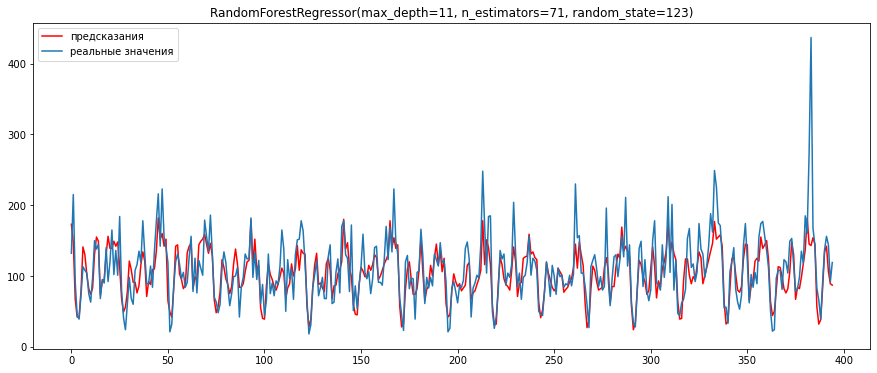

In [48]:
predictions1 = test(rfreg, name='rfreg')
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу

C:\Users\79853\miniconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


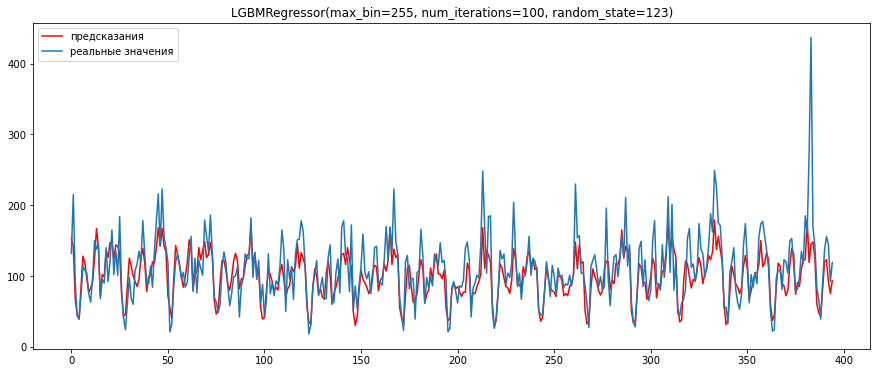

In [49]:
predictions2 = test(lgbmreg, name='lgbmreg')
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу

In [50]:
result_tbl

,model_name,model,time_sec,RMSE,process
0,rfreg,"(DecisionTreeRegressor(max_depth=11, max_featu...",0.8,12,обучение
0,lgbmreg,"LGBMRegressor(max_bin=255, num_iterations=100,...",0.1,14,обучение
0,xgbreg,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.1,19,обучение
0,linear,LinearRegression(),0.0,22,обучение
0,rfreg,"(DecisionTreeRegressor(max_depth=11, max_featu...",0.0,30,тестирование
0,lgbmreg,"LGBMRegressor(max_bin=255, num_iterations=100,...",0.0,31,тестирование


В совокупности показателей на обучении и тестировании лучшей является модель:
- **rfreg = RandomForestRegressor(max_depth=11, n_estimators'=71, random_state=123)**

In [51]:
print("\033[1m" + "Результаты выбранной модели" + "\033[0;0m")
result_tbl.loc[result_tbl.model_name == 'rfreg']

Результаты выбранной модели


,model_name,model,time_sec,RMSE,process
0,rfreg,"(DecisionTreeRegressor(max_depth=11, max_featu...",0.8,12,обучение
0,rfreg,"(DecisionTreeRegressor(max_depth=11, max_featu...",0.0,30,тестирование


## Общий вывод

В ходе проекта были исследованы исторические данные о заказах такси: дата и время, количество заказов, - с целью построения модели для предсказания количества заказов такси на следующий час.

На этапе **подготовки данных** из поля `datetime` был сформирован индекс, было проверено, расположены ли данные в хронологическом порядке, также были сформированы ресемплированные ряды (по одному часу, по одному дню, по одной неделе, по одному месяцу).

На этапе **анализа данных** были рассмотрены графики временных рядов исходного датасета и ресемплированных данных, по ним был установлен тренд увеличения количества заказов к августу.

В **п.2.1** были построены графики тренда и сезонной компоненты временного ряда, ресемплированного по часу. При этом были рассмотрены несколько временных интервалов из ряда: 6 месяцев, 1 месяц, 1 неделя, 1 неделя с дополнительными выходными, 1 день. Выявлены тренд увеличения числа заказов такси с мая по август, а также суточная сезонность. График тренда за неделю показал увеличение заказов в первый рабочий день после выходных и в первый выходной день после рабочих. График сезонности за один день показал, что меньше всего заказов приходится на 6 утра, больше всего - на 12 ночи. 

В **п.2.2** были рассчитаны скользящие средние по дням и по неделям. Сглаживание по дням лучше показало динамику заказов в течение недели, а недельное сглаживание хорошо отразило общие изменения, связанные с ростом заказов к августу. 

В **п.2.3** была проведена проверка временного ряда на стационарность. В соответствии с результатами теста Дики–Фуллера было определено, что исходные данные и данные, ресемплированные по часу, являются стационарными рядами.

В **п.2.4** были созданы признаки для обучения модели, помимо календарных признаков, добавлены средние значения заказов по дням недели и по часам, отстающие значения и скользящее среднее.

В **п.3** были обучены четыре модели регрессии: RandomForestRegressor(), LGBMRegressor(), 
XGBRegressor(), LinearRegression(). С помощью GridSearchCV() для них были подобраны несколько гиперпараметров для увеличения качества предсказаний. 

Лучшие результаты показала модель **RandomForestRegressor(max_depth=11, n_estimators'=71, random_state=123)**:
- RMSE на обучающей выборке - 12,
- RMSE на тестовой выборке - 30.